# lab6

In [1]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [2]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

In [3]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --only-binary=:all: "tiktoken>=0.7.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 77.9 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install "jupyter-ai-magics[all]" -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
safety-schemas 0.0.14 requires pydantic<2.10.0,>=2.6.0, but you have pydantic 2.12.0 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


## 3. Q1 – Population Growth Rate 

In [6]:
! pip install jupyter-ai-magics[all] -q

In [7]:
import warnings
warnings.simplefilter('ignore')

In [8]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [9]:
%load_ext jupyter_ai_magics

In [10]:
q1_sql = """
SELECT
    p1.fips,
    n.name AS state_name,
    p1.year,
    p1.pop AS population,
    ROUND(
        ( (p1.pop - p2.pop)::numeric / p2.pop ) * 100,
        2
    ) AS growth_rate_percent
FROM population p1
JOIN population p2
    ON p1.fips = p2.fips
    AND p1.year = p2.year + 1
JOIN name n
    ON p1.fips = n.fips
WHERE n.name = 'Rhode Island'   -- ← replace with your state
ORDER BY p1.year;

     """

In [11]:
import pandas as pd

q1_df = pd.read_sql(q1_sql, con=conn)
q1_df.head() #show the top 5 rows

,fips,state_name,year,population,growth_rate_percent
0,44,Rhode Island,2006,1067610,3.38
1,44,Rhode Island,2007,1057832,-0.92
2,44,Rhode Island,2008,1050788,-0.67
3,44,Rhode Island,2009,1053209,0.23
4,44,Rhode Island,2010,1052886,-0.03


In [14]:
%%ai gpt4 -f code
use the data in dataframe {q1_df} to  create a line chart to show the growth rate. Make sure use the dataframe name q1_df
• Chart must include the state name in the title. 


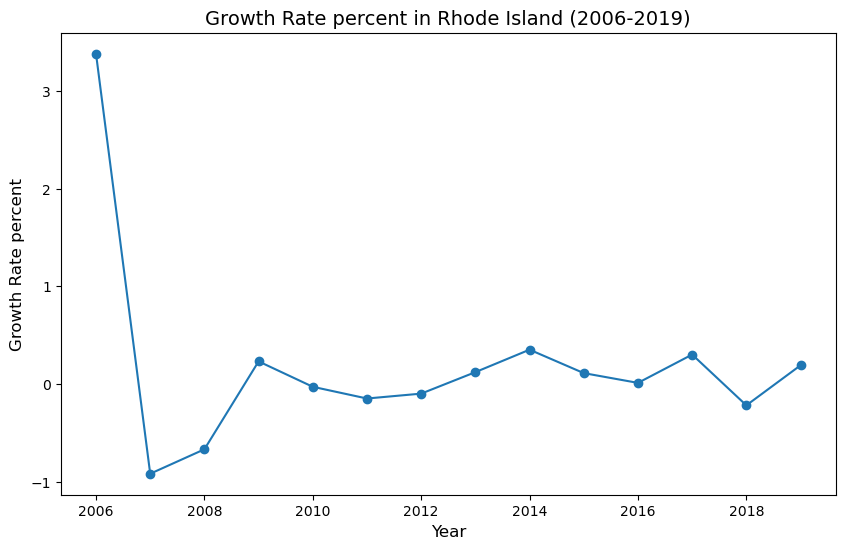

In [15]:
import matplotlib.pyplot as plt

# Creating a line chart for growth rate
plt.figure(figsize=(10,6))
plt.plot(q1_df['year'], q1_df['growth_rate_percent'], marker='o')

# Adding title and labels
plt.title('Growth Rate percent in Rhode Island (2006-2019)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Growth Rate percent', fontsize=12)

# Displaying the plot
plt.show()

This graph shows the population rate of Rhode Island from 2006 to 2019. After 2006, there was a sudden drop in the population, and then a slight increase in 2008. Since that time, population growth has stayed at a steady level.

# Q2 – Income and Population Relationship

In [18]:
q2_sql = """
SELECT
    p1.fips,
    n.name AS state_name,
    p1.year,
    p1.pop AS income,
    ROUND(
        ( (p1.pop - p2.pop)::numeric / p2.pop ) * 100,
        2
    ) AS growth_rate_percent
FROM population p1
JOIN population p2
    ON p1.fips = p2.fips
    AND p1.year = p2.year + 1
JOIN name n
    ON p1.fips = n.fips
WHERE n.name = 'Rhode Island'   -- ← replace with your state
ORDER BY p1.year;

     """

In [19]:
import pandas as pd

q2_df = pd.read_sql(q1_sql, con=conn)
q2_df.head() #show the top 5 rows

,fips,state_name,year,income,growth_rate_percent
0,44,Rhode Island,2006,1067610,3.38
1,44,Rhode Island,2007,1057832,-0.92
2,44,Rhode Island,2008,1050788,-0.67
3,44,Rhode Island,2009,1053209,0.23
4,44,Rhode Island,2010,1052886,-0.03


In [20]:
%%ai gpt4 -f code
use the data in dataframe {q2_df} to create a dual-axis line chart showing the income and growth rate percent over the years make sure use the dataframe name q2_df
• Chart must include the state name in the title.

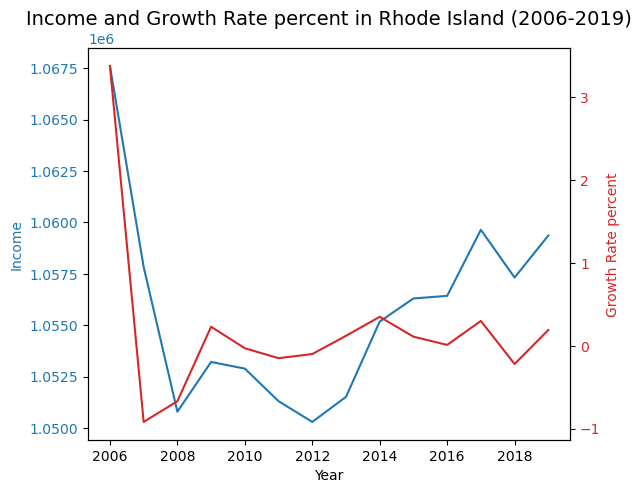

In [21]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Income', color=color)
ax1.plot(q2_df['year'], q2_df['income'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Growth Rate percent', color=color) 
ax2.plot(q2_df['year'], q2_df['growth_rate_percent'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Income and Growth Rate percent in Rhode Island (2006-2019)', fontsize=14)
plt.show()

In this graph, we see both the data on population growth and the income rate in Rhode Island. Similar to population growth, it took a sharp decline in 2006, although it rebounded and then remained at steady levels. Population growth and income levels mirrored each other throughout the graph in the general census.

# Q3 – Student-Defined Question

In [22]:
q3_sql = """
SELECT 
    p1.year AS year,
    (p1.pop - p2.pop) AS population_increase
FROM population p1
JOIN population p2
    ON p1.fips = p2.fips
    AND p1.year = p2.year + 1
WHERE p1.fips = '44'       -- Rhode Island
ORDER BY population_increase DESC
LIMIT 1;


     """

In [23]:
import pandas as pd

q3_df = pd.read_sql(q3_sql, con=conn)
q3_df.head() #show the top 5 rows

,year,population_increase
0,2006,34948


In [24]:
%%ai gpt4 -f code
use the data in dataframe {q3_df} to create a bar chart, make sure use the dataframe name q3_df

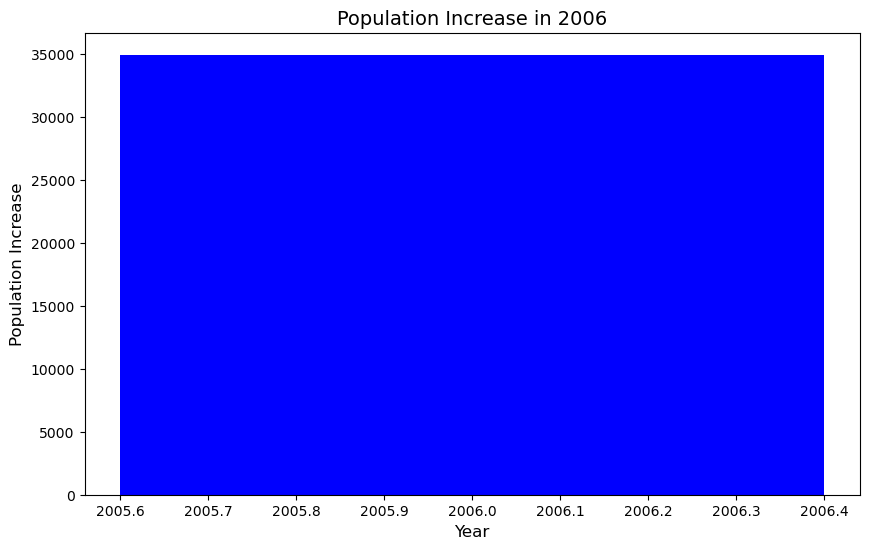

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(q3_df['year'], q3_df['population_increase'], color='blue')

# Adding title and labels
plt.title('Population Increase in 2006', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Population Increase', fontsize=12)

plt.show()

This graph shows the population increase in the state of Rhode Island in 2006. We can see that the population growth remains steady throughout the year. The population growth in 2006 peaked at approximately 35,000 births.

In [27]:
cur.close()
conn.close()